In [ ]:
import pandas as pd
import numpy as np
import os
import scipy
from scipy.interpolate import griddata
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.nn.functional import mse_loss
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(f"Using device: {device}")

class Swish(nn.Module):
    def __init__(self, inplace=True):
        super(Swish, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        if self.inplace:
            x.mul_(torch.sigmoid(x))
            return x
        else:
            return x * torch.sigmoid(x)


class NavierStokesPINN_U(torch.nn.Module):
    def __init__(self):
        super(NavierStokesPINN_U, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

class NavierStokesPINN_V(torch.nn.Module):
    def __init__(self):
        super(NavierStokesPINN_V, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

class NavierStokesPINN_P(torch.nn.Module):
    def __init__(self):
        super(NavierStokesPINN_P, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(4, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 50),
            Swish(),
            torch.nn.Linear(50, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

Using device: cuda


In [3]:
#Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.inputs = torch.tensor(data[:, [0, 1, 5, 7]], dtype=torch.float32).to(device)
        self.targets = torch.tensor(data[:, [2, 3, 4]], dtype=torch.float32).to(device)


    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [4]:
# Define absolute paths for saved weights
weights_dir = r"models\original"  # Use raw string (r"...") to avoid escape character issues
e_idx = 282
model_1_path = os.path.join(weights_dir, f"original_1_epoch_{e_idx}.pth")
model_2_path = os.path.join(weights_dir, f"original_2_epoch_{e_idx}.pth")
model_3_path = os.path.join(weights_dir, f"original_3_epoch_{e_idx}.pth")

def initialize_models():
    # Move models to GPU
    model_1 = NavierStokesPINN_U().to(device)
    model_2 = NavierStokesPINN_V().to(device)
    model_3 = NavierStokesPINN_P().to(device)

    print(f"Model_1 is on: {next(model_1.parameters()).device}")
    print(f"Model_2 is on: {next(model_2.parameters()).device}")
    print(f"Model_3 is on: {next(model_3.parameters()).device}")


    optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
    optimizer_2 = optim.Adam(model_2.parameters(), lr=1e-3)
    optimizer_3 = optim.Adam(model_3.parameters(), lr=1e-3)

        # Load saved weights if they exist
    if os.path.exists(model_1_path):
        model_1.load_state_dict(torch.load(model_1_path))
        model_1.train()
        print(f"✅ Loaded weights from {model_1_path}")
    else:
        print(f"⚠️ No saved weights found at {model_1_path}. Training from scratch.")

    if os.path.exists(model_2_path):
        model_2.load_state_dict(torch.load(model_2_path))
        model_2.train()
        print(f"✅ Loaded weights from {model_2_path}")
    else:
        print(f"⚠️ No saved weights found at {model_2_path}. Training from scratch.")

    if os.path.exists(model_3_path):
        model_3.load_state_dict(torch.load(model_3_path))
        model_3.train()
        print(f"✅ Loaded weights from {model_3_path}")
    else:
        print(f"⚠️ No saved weights found at {model_3_path}. Training from scratch.")

    return model_1, model_2, model_3, optimizer_1, optimizer_2, optimizer_3

In [ ]:
def compute_distance(x, y, d, n):
    """Compute the minimum distance of (x, y) from the nearest circular post."""
    tilt = 0.4/n
    centers = [(0, 0), (0, 0.4), (0.4, tilt), (0.4, 0.4+tilt)]
    
    distances = torch.full_like(x, float("inf"))  # Initialize distances with large values

    for cx, cy in centers:
        r = d / 2
        distance_to_post = torch.sqrt((x - cx) ** 2 + (y - cy) ** 2) - r
        distances = torch.minimum(distances, distance_to_post)  # Take the minimum distance

    return torch.maximum(distances, torch.tensor(0.0))  # Set negative distances to zero


def criterion(x_batch, y_batch, model_1, model_2, model_3, mse_loss, v_loss_weight, rho=1.0, nu=0.01):
    """
    Computes the loss based on physics-based PDE constraints and data loss.

    Args:
    - x_batch: Input tensor (batch of input values)
    - y_batch: Target tensor (batch of true output values)
    - model_1, model_2, model_3: Neural network models for u, v, and p
    - mse_loss: MSE loss function
    - rho: Density parameter for PDE constraints
    - nu: Viscosity parameter for PDE constraints

    Returns:
    - Total loss: Sum of physics loss and data loss
    """
    # Compute model predictions inside criterion
    x, y, d, n = x_batch[:, 0:1], x_batch[:, 1:2], x_batch[:, 2:3], x_batch[:, 3:4]
    
    x.requires_grad_(True)
    y.requires_grad_(True)
    d.requires_grad_(True)
    n.requires_grad_(True)

    model_inputs = torch.cat((x, y, d, n), dim=1)  # Concatenate inputs for the models

    # some sort of ways to actually define the pairs inside of these 50000 points.
    u = model_1(model_inputs)
    v = model_2(model_inputs)
    p = model_3(model_inputs)
    #print(u.shape)
    u = u.view(len(u),-1)
    v = v.view(len(v),-1)
    p = p.view(len(p),-1)
    #print(u.shape)
    
    # Compute distance to the nearest circular post
    distances = compute_distance(x, y, d, n)
    u[distances == 0] = 0
    v[distances == 0] = 0
    v[x == 0] = 0  #inlet y velocity
    p[x == 0.4] = 0
    u_loss = mse_loss(u, y_batch[:, 0:1])
    v_loss = mse_loss(v, y_batch[:, 1:2])
    p_loss = mse_loss(p, y_batch[:, 2:3])


    # Compute data loss (MSE against target values)
    L_data = ( u_loss + v_loss * v_loss_weight + p_loss )
    #L_data_periodic = ( u_p_loss + v_loss * 500 + p_loss )

    # l_data_periodic + L


    return L_data, u_loss, v_loss, p_loss


In [ ]:
#loss track

def main():
    # Load dataset (modify file path accordingly)
    file_path = os.path.join(os.getcwd(), "data/merged_dataset_REU.parquet")

    # Load data using pandas and convert to NumPy array
    df = pd.read_parquet(file_path)  # Load Parquet file
    data = df.to_numpy(dtype=np.float32)  # Convert to NumPy array
    
    dataset = CustomDataset(data)
    drt = len(dataset)
    dataloader = DataLoader(dataset, batch_size=100000, shuffle=True)
    print(drt)
    num_batches = len(dataloader)
    print(num_batches)

    # Initialize models and optimizers
    model_1, model_2, model_3, optimizer_1, optimizer_2, optimizer_3 = initialize_models()

    # Training loop
    num_epochs = 500
    mse_loss = nn.MSELoss()
    start_time = time.time()
    
    # Initialize minimum loss to a large value
    min_loss = float('inf')
    
    # Lists to store loss history
    loss_history = {
        'epoch': [],
        'total_loss': [],
        'u_loss': [],
        'v_loss': [],
        'p_loss': []
    }

    v_loss_weight = 20
    
    for epoch in range(num_epochs):
        total_loss, total_u_loss, total_v_loss, total_p_loss = 0, 0, 0, 0
        num_batches = len(dataloader)

        if epoch > 100:
            v_loss_weight = 50

        if epoch > 200:
            v_loss_weight = 100
        
        if epoch > 300:
            v_loss_weight = 200

        if epoch > 400:
            v_loss_weight = 500
        
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, u_loss, v_loss, p_loss = criterion(x_batch, y_batch, model_1, model_2, model_3, mse_loss, v_loss_weight)

    
            optimizer_1.zero_grad()
            optimizer_2.zero_grad()
            optimizer_3.zero_grad()
            loss.backward()
            optimizer_1.step()
            optimizer_2.step()
            optimizer_3.step()
    
            # Accumulate loss values
            total_loss += loss.item()
            total_u_loss += u_loss.item()
            total_v_loss += v_loss.item()
            total_p_loss += p_loss.item()
    
        # Compute average loss
        avg_loss = total_loss / num_batches
        avg_u_loss = total_u_loss / num_batches
        avg_v_loss = total_v_loss / num_batches
        avg_p_loss = total_p_loss / num_batches
        
        # Store losses in history
        loss_history['epoch'].append(epoch)
        loss_history['total_loss'].append(avg_loss)
        loss_history['u_loss'].append(avg_u_loss)
        loss_history['v_loss'].append(avg_v_loss)
        loss_history['p_loss'].append(avg_p_loss)
        
        # Save models if the current loss is lower than the minimum loss
        if avg_loss < min_loss:
            min_loss = avg_loss
            torch.save(model_1.state_dict(), f'models/original/original_1_epoch_{epoch}.pth')
            torch.save(model_2.state_dict(), f'models/original/original_2_epoch_{epoch}.pth')
            torch.save(model_3.state_dict(), f'models/original/original_3_epoch_{epoch}.pth')
            print(f"Epoch {epoch}: New minimum loss {min_loss:.7f}, models saved")
    
        if epoch % 2 == 0:
            elapsed_time = time.time() - start_time
            print(f"Epoch [{epoch}/{num_epochs}], Avg Loss: {avg_loss:.7f}, Avg ULoss: {avg_u_loss:.7f}, "
                  f"Avg VLoss: {avg_v_loss:.7f}, Avg PLoss: {avg_p_loss:.7f}, Time: {elapsed_time:.2f} sec")
            start_time = time.time()

    # Save losses to CSV
    loss_df = pd.DataFrame(loss_history)
    loss_df.to_csv('results/original/training_losses_original.csv', index=False)
    
    # Plot loss curves
    plt.figure(figsize=(12, 8))
    plt.plot(loss_history['epoch'], loss_history['total_loss'], label='Total Loss')
    plt.plot(loss_history['epoch'], loss_history['u_loss'], label='U Loss')
    plt.plot(loss_history['epoch'], loss_history['v_loss'], label='V Loss')
    plt.plot(loss_history['epoch'], loss_history['p_loss'], label='P Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epoch')
    plt.legend()
    plt.yscale('log')  # Use log scale for better visualization
    plt.grid(True)
    plt.savefig('results/original/loss_curves_original.png')
    plt.show()

    return model_1, model_2, model_3


2160000
22
Model_1 is on: cuda:0
Model_2 is on: cuda:0
Model_3 is on: cuda:0
⚠️ No saved weights found at models\original\original_1_epoch_282.pth. Training from scratch.
⚠️ No saved weights found at models\original\original_2_epoch_282.pth. Training from scratch.
⚠️ No saved weights found at models\original\original_3_epoch_282.pth. Training from scratch.
Epoch 0: New minimum loss 1.0853218, models saved
Epoch [0/500], Avg Loss: 1.0853218, Avg ULoss: 0.0013432, Avg VLoss: 0.0021645, Avg PLoss: 0.0017346, Time: 17.01 sec
Epoch 1: New minimum loss 0.0838471, models saved
Epoch 2: New minimum loss 0.0386723, models saved
Epoch [2/500], Avg Loss: 0.0386723, Avg ULoss: 0.0008674, Avg VLoss: 0.0000755, Avg PLoss: 0.0000711, Time: 33.06 sec
Epoch 3: New minimum loss 0.0325439, models saved
Epoch 4: New minimum loss 0.0311832, models saved
Epoch [4/500], Avg Loss: 0.0311832, Avg ULoss: 0.0008538, Avg VLoss: 0.0000605, Avg PLoss: 0.0000577, Time: 32.39 sec
Epoch 5: New minimum loss 0.0306826, 

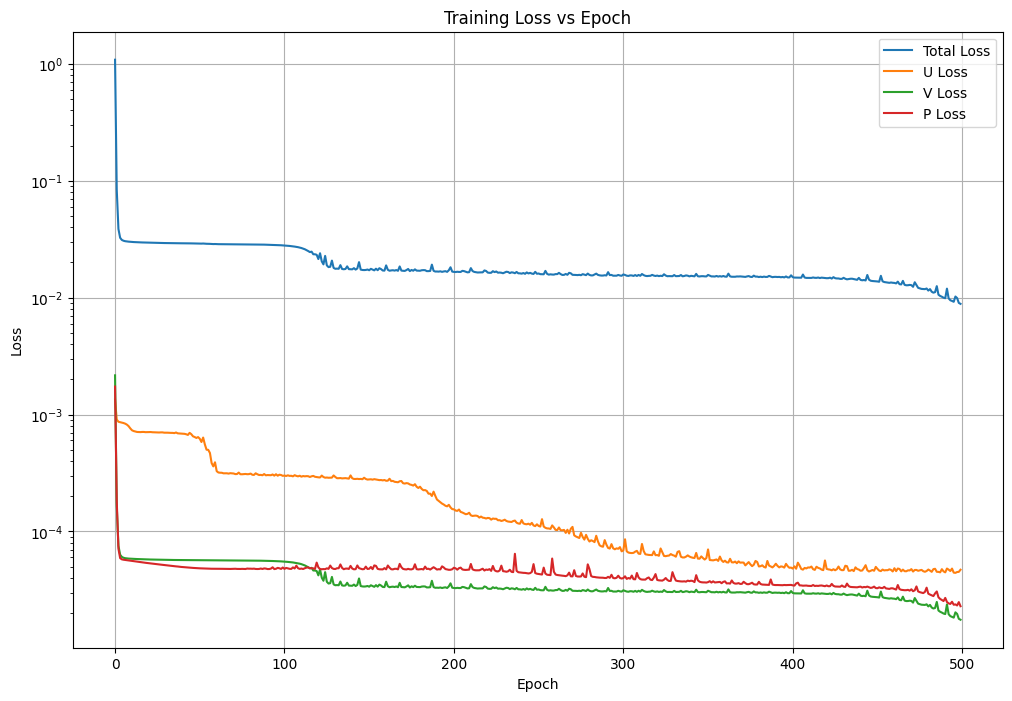

In [7]:
model_1, model_2, model_3 = main()

In [8]:
# Set models to evaluation mode
model_1.eval()
model_2.eval()
model_3.eval()

NavierStokesPINN_P(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): Swish()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Swish()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Swish()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [9]:
# PREDICTION USING HARD ENFORCEMENT

# File path
file_path = "data/csv/W_0.55_14_1.csv"

# Load CSV file
df = pd.read_csv(file_path)

# Ensure the correct columns are selected for input
input_data = df.iloc[:, [0, 1, 5, 7]].values  # Selecting columns (x, y, d, N)
output_data = df.iloc[:, [2, 3, 4]].values  # Selecting columns (u, v, p)

# Convert to PyTorch tensor and move to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)

# Define function to compute the minimum distance from the nearest circular post
def compute_distance(x, y, d, n):
    """Compute the minimum distance of (x, y) from the nearest circular post."""
    tilt = 0.4 / n
    centers = [(0, 0), (0, 0.4), (0.4, tilt), (0.4, 0.4 + tilt)]
    
    distances = torch.full_like(x, float("inf"))  # Initialize distances with large values

    for cx, cy in centers:
        r = d / 2
        distance_to_post = torch.sqrt((x - cx) ** 2 + (y - cy) ** 2) - r
        distances = torch.minimum(distances, distance_to_post)  # Take the minimum distance

    return torch.maximum(distances, torch.tensor(0.0, device=device))  # Set negative distances to zero

# Make predictions
with torch.no_grad():
    u_pred = model_1(input_tensor)
    v_pred = model_2(input_tensor)
    p_pred = model_3(input_tensor)

# Extract individual elements
x, y, d, n = input_tensor[:, 0], input_tensor[:, 1], input_tensor[:, 2], input_tensor[:, 3]

# Apply conditions
v_pred[x == 0] = 0  # If x = 0, set v_pred to zero

# Compute distance
distances = compute_distance(x, y, d, n)

# If distance is zero, set u and v to zero
mask = distances == 0
u_pred[mask] = 0
v_pred[mask] = 0

# Move predictions to CPU and convert to NumPy
u_pred = u_pred.cpu().numpy()
v_pred = v_pred.cpu().numpy()
p_pred = p_pred.cpu().numpy()


In [10]:
#prediction for NO MODIFICATION
import pandas as pd
import torch
import numpy as np

# File path
file_path = "data/csv/W_0.55_14_1.csv"

# Load CSV file
df = pd.read_csv(file_path)

# Ensure the correct columns are selected for input (same format as training)
input_data = df.iloc[:, [0, 1, 5, 7]].values  # Selecting columns (x, y, d)
output_data = df.iloc[:, [2, 3, 4]].values  # Selecting columns (x, y, d)

# Convert to PyTorch tensor and move to GPU (if available)
input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)

with torch.no_grad():
    u_pred = model_1(input_tensor)
    v_pred = model_2(input_tensor)
    p_pred = model_3(input_tensor)

# Move predictions to CPU and convert to NumPy
u_pred = u_pred.cpu().numpy()
v_pred = v_pred.cpu().numpy()
p_pred = p_pred.cpu().numpy()


In [11]:
x_grid = input_data[:, 0].reshape(-1)
y_grid = input_data[:, 1].reshape(-1)
v_actual_grid = output_data[:, 1].reshape(-1)
v_pred_grid = v_pred.flatten()
u_actual_grid = output_data[:, 0].reshape(-1)
u_pred_grid = u_pred.flatten()

In [ ]:
# Create a DataFrame
df = pd.DataFrame({
    'x': x_grid,
    'y': y_grid,
    'u': u_pred_grid,
    'v': v_pred_grid
})

# Save to CSV
df.to_csv('results/original/csv/O_0.55_14.csv', index=False)

print("CSV file saved successfully!")

CSV file saved successfully!


In [13]:
v_pred_grid.shape

(18000,)

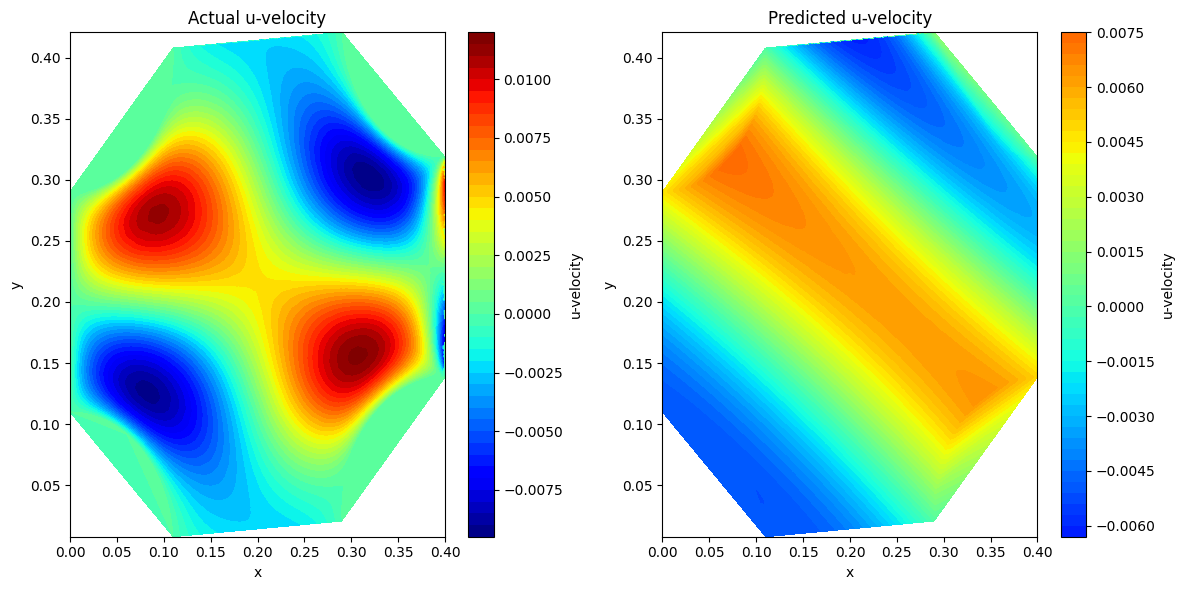

In [14]:
%matplotlib inline

# Determine the common range for colorbar
vmin = min(v_actual_grid.min(), v_pred_grid.min())
vmax = max(v_actual_grid.max(), v_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, v_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Actual u-velocity')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, v_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Predicted u-velocity')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()


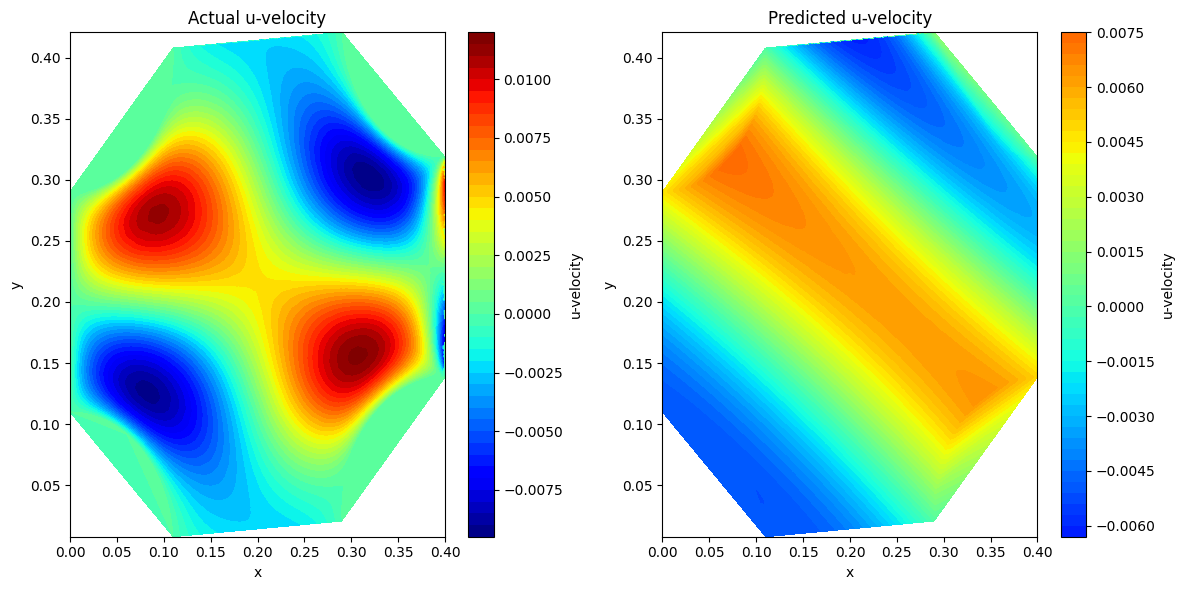

In [15]:
%matplotlib inline

# Determine the common range for colorbar
vmin = min(v_actual_grid.min(), v_pred_grid.min())
vmax = max(v_actual_grid.max(), v_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, v_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Actual u-velocity')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, v_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Predicted u-velocity')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()


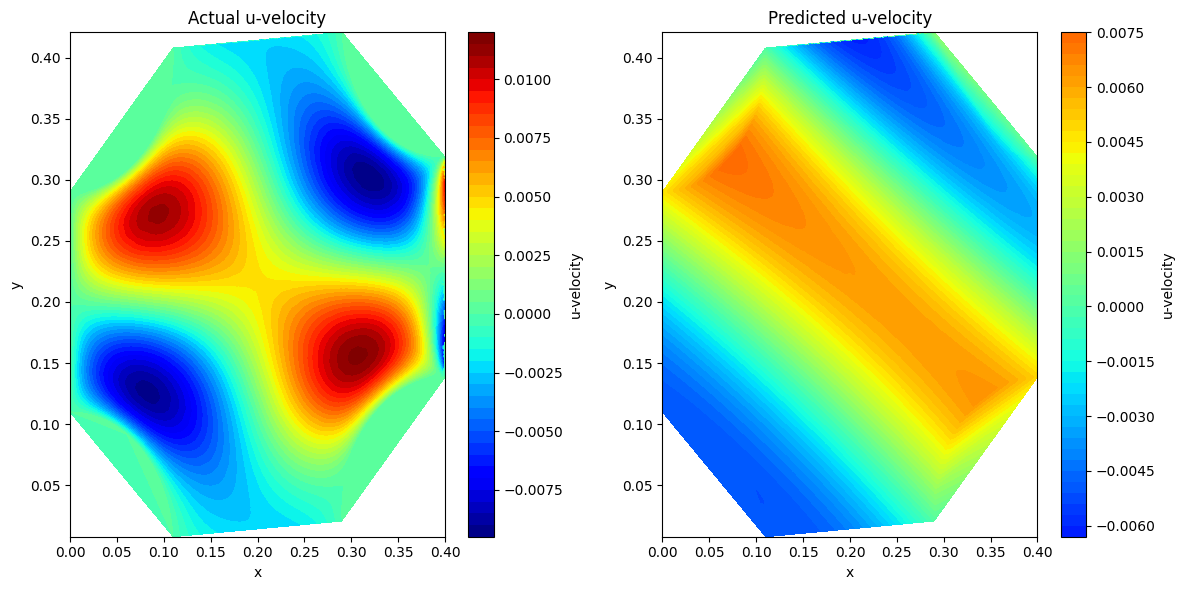

In [16]:
%matplotlib inline

# Determine the common range for colorbar
vmin = min(v_actual_grid.min(), v_pred_grid.min())
vmax = max(v_actual_grid.max(), v_pred_grid.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, v_actual_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Actual u-velocity')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_grid, y_grid, v_pred_grid, levels=50, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar(label='u-velocity')
plt.title('Predicted u-velocity')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()
